# Fitting a mass model

This tutorial explains how to use _hydromass_ and _pyproffit_ to fit a mass model to X-ray data from a galaxy cluster under the assumption that the gas is in hydrostatic equilibrium. The chosen example is applied to XMM-Newton observations of the massive galaxy cluster MACS 0451 at z=0.54, which were published in [Tam et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.496.4032T/abstract) and was found to be in excellent agreement with the gravitational lensing data.

The provided test data include a soft-band (0.7-1.2 keV) image of the cluster with an exposure and a non X-ray background map, as well as a spectroscopic temperature profile extracted by fitting an APEC model to XMM-Newton spectra extracted in concentric annuli. We refer to [Ghirardini et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...621A..41G/abstract) for details on the data analysis procedure.

Let's start by loading the packages...

In [1]:
import numpy as np

import pyproffit

import hydromass

import matplotlib.pyplot as plt


We start by loading the images in pyproffit using the pyproffit.Data class. We refer to the [_pyproffit_ documentation](https://pyproffit.readthedocs.io) for more details.

1. Here imglink=_'epic-obj-im-700-1200.fits'_ is the link to the image file (count map) to be loaded.
2. The option _explink=_'epic-exp-im-700-1200.fits' allows the user to load an exposure map for vignetting correction. In case this option is left blank, a uniform exposure of 1s is assumed for the observation.   
3. The option _bkglink=_'epic-back-oot-sky-700-1200.fits' allows to load an external background map, which will be used when extracting surface brightness profiles.

The images are then loaded into the _Data_ structure

In [2]:
datv = pyproffit.Data(imglink='../../test_data/epic-obj-im-700-1200.fits',
                    explink='../../test_data/epic-exp-im-700-1200.fits',
                    bkglink='../../test_data/comb-back-tot-sky-700-1200.fits')


# Filter out point sources by loading a DS9 region file
datv.region('../../test_data/src_mask.reg')



Excluded 41 sources


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 53265.507373 from DATE-END'. [astropy.wcs.wcs]


## Profile extraction ##

Now we define a _Profile_ object and fit the background with a constant. We refer to the [_pyproffit_ documentation](https://pyproffit.readthedocs.io) for the details of the surface brightness profile extraction

In [3]:
prof = pyproffit.Profile(datv, center_choice='peak', binsize=5, maxrad=15.)


prof.SBprofile()

Determining X-ray peak
Coordinates of surface-brightness peak: 428.0 416.0
Corresponding FK5 coordinates:  73.5456401039549 -3.0148262711063816


The cluster being at relatively high redshift, it is well contained within the XMM-Newton field of view. Therefore we can fit the data at large radii with a constant brightness model to determine the local sky background emission. Here we assume that the brightness beyond 7 arcmin from the cluster center is completely dominated by the sky background...

In [4]:
mod = pyproffit.Model(pyproffit.Const)
fitter = pyproffit.Fitter(model=mod, profile=prof, bkg=-3.8, fitlow=7., fithigh=15.)
fitter.Migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 122.6                      │              Nfcn = 30               │
│ EDM = 9.85e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

<Figure size 432x288 with 0 Axes>

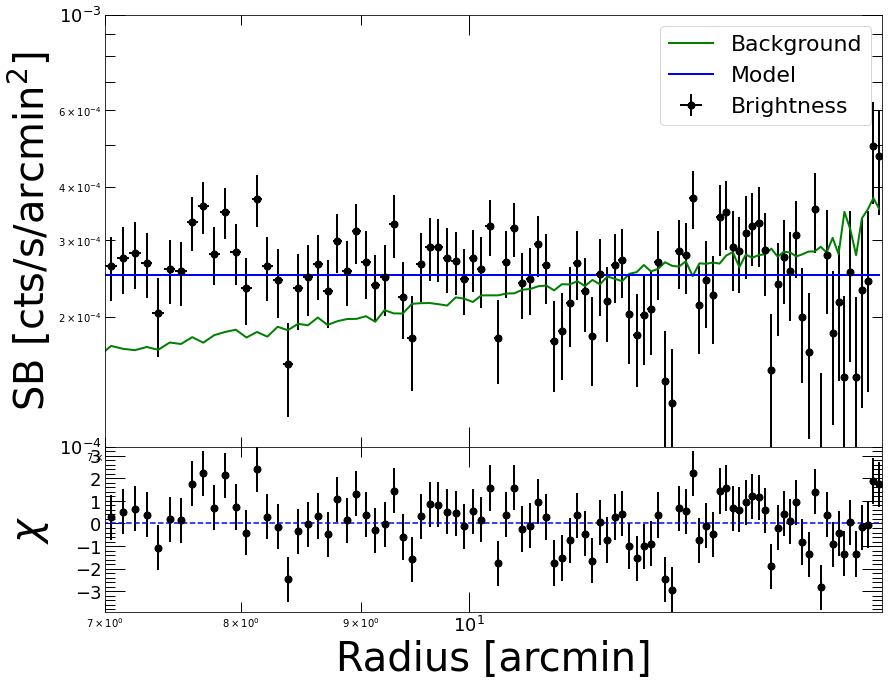

In [5]:
prof.Plot(model=mod, axes=[7., 15., 1e-4, 1e-3])

We can see that the background beyond 7 arcmin is reasonably flat and thus can be reliably subtracted to determine the source profile. 

Now we extract a new profile with logarithmic binning and subtract the background...

Determining X-ray peak
Coordinates of surface-brightness peak: 428.0 416.0
Corresponding FK5 coordinates:  73.5456401039549 -3.0148262711063816


<Figure size 432x288 with 0 Axes>

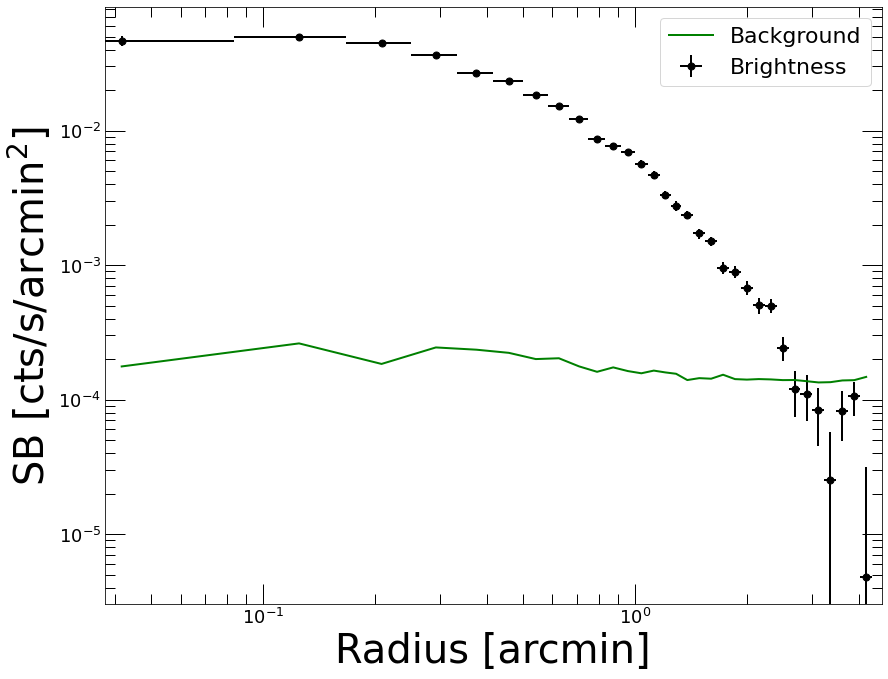

In [6]:
p2 = pyproffit.Profile(datv, center_choice='peak', binsize=5, maxrad=4.5, binning='log')

p2.SBprofile()

p2.Backsub(fitter)

p2.Plot()

## Modeling the PSF ##

To model the PSF we can either supply a function or an image. The function should take an array of radii (in arcmin) and return the 1D PSF profile. Here the provided function gives a good description of the on-axis XMM-Newton PSF. Again we refer to the _pyproffit_ documentation for more details on this part.


In [7]:
def fking(x):
    r0=0.0883981
    alpha=1.58918
    return np.power(1.+(x/r0)**2,-alpha)

p2.PSF(psffunc=fking)


The final profile and the PSF mixing matrix can now be saved into an output FITS file to be reloaded later and avoid re-extracting the profiles,

In [8]:
p2.Save(outfile='mhyd/test_sb_profile.fits')

## Defining the model ##

Now that we have extracted the surface brightness profile we can define the mass model and load the appropriate data into it. This is done through the [hydromass.Mhyd](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.mhyd.Mhyd) class. 

X-ray spectral fitting results (temperature, normalization, and metal abundance) can be loaded using the [hydromass.SpecData](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.tpdata.SpecData) class. The data can be passed either in the form a FITS table file including the definition of the radial binning and the spectral results, or directly as numpy arrays. An SZ pressure profile and its covariance matrix can be loaded in a similar way using the [hydromass.SZData](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.tpdata.SZData) class.

Here we load the spectral results FITS file provided as part of the test data. We also compute a PSF mixing matrix that is appropriate for the radial binning of the spectral results, using the same PSF model as for the surface brightness.

In [9]:
z_m0451 = 0.5398 # Source redshift

spec_data = hydromass.SpecData(redshift=z_m0451,
                               spec_data='../../test_data/spectral_results_MACS0451.fits')

spec_data.PSF(pixsize=2.5/60., 
              psffunc=fking)


Reading spectral data from file ../../test_data/spectral_results_MACS0451.fits


The constructor of the Mhyd class requires the following input:

- profile=_prof_: a [pyproffit.Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) object including the SB profile
- spec_data=_file_: a [hydromass.SpecData](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.tpdata.SpecData) object containing the X-ray spectroscopic temperature profile
- sz_data=_file_: a [hydromass.SZData](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.tpdata.SZData) containing an SZ pressure profile and its covariance matrix
- redshift=_z_: source redshift
- cosmo=_cosmo_: adopted cosmology in astropy.cosmology format. If cosmo=None (default), use Planck15.
- directory=_dir_: name of output file directory. If directory=None (default), a subdirectory with name 'mhyd' will be created.
- f_abund='_angr_': abundance table definition for calculation of electron to proton ratio and mean molecular weight. Default='angr', also available are 'aspl' and 'grsa'

Note that either spec_data or sz_data or both can be specified. In case both a spectroscopic temperature profile and an SZ pressure profile are provided the two datasets or fitted jointly. 

In [10]:
tmhyd = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z_m0451)


No output directory name provided, will output to subdirectory "mhyd" 
No cosmology provided, will default to Planck15
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc


Now let's define a mass model. This is done with the [hydromass.Model](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.functions.Model) class, which accepts the following option:

- massmod=_NFW_: mass model definition. Available models are 'NFW', 'EIN2', 'EIN3', 'BUR', 'ISO', and 'HER'.
- delta=_val_: overdensity at which R_delta and c_delta are defined in the model (default=200).
- start=_start_: an array containing the mean values of the Gaussian priors on the parameters. If None, default values for each model will be set.
- sd=_sd_: an array contianing the sigma of the Gaussian priors on the parameters. If None, default values for each model will be set.
- limits=_limits_: a 2D-array containing upper and lower limits for the parameter values. If None, default values for each model will be set.
- fixed=_fix_: a boolean array describing if a parameter is fixed or fitted. For instance, for a model with 2 parameters for which we want to fix the first one, we pass fix=[True, False]. If fix=True, the value given in start is used. By default all parameters are fitted.

To begin with, we fit an NFW model with broad Normal priors on concentration and overdensity radius. We also set the acceptable ranges of the model parameters, which here are very broad.

In [11]:
start = [4., 2000.] # Central values of the Normal prior on concentration and overdensity radius (in kpc)

sd = [3., 1000.] # Standard deviation of the Normal prior

limits = np.array([[0.5, 10.],[300., 4000.]]) # Lower and upper boundaries on the model parameters

model = hydromass.Model(massmod='NFW',
                       start=start,
                       sd=sd,
                       limits=limits)


Here we have set the following priors

$$ c_{200} \sim \mathcal{N}(4, 3) $$
$$ R_{200} \sim \mathcal{N}(2000, 1000)$$

To determine the conversion between detector count rate and intrinsic emission measure, we need to simulate an absorbed APEC model spectrum with known emission measure and fold it through the response of the instrument. This is done through the [hydromass.Mhyd.emissivity](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.mhyd.Mhyd.emissivity), which uses a model spectrum to relate the normalization of the APEC model with the expected source count rate. An XSPEC command under the hood, so XSPEC must be accessible. If no temperature is provided, the mean spectral temperature of the loaded spectroscopic temperature profile is used.

Since we are observing in a soft energy band (0.7-1.2 keV), the emissivity is a weak function of temperature and can be assumed to be constant across the radial range given the average cluster temperature of 8 keV. This is not necessarily the case for galaxy groups, for which the emissivity depends substantially on temperature and metallicity.

In [12]:
nh_m0451 = 0.0454 # Galactic NH

rsp = '/Users/deckert/Documents/Work/devel/hydromass/test_data/m1.rsp' # on-axis response file

tmhyd.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

print('Conversion between count rate and emission measure: ', tmhyd.ccf)

Mean cluster temperature: 8.161195  keV
m1

		XSPEC version: 12.12.0
	Build Date/Time: Fri Jan 14 18:24:26 2022

XSPEC12>cosmo 67.74 0 0.69101
XSPEC12>abund angr
 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
XSPEC12>model phabs(apec)

Input parameter value, delta, min, bot, top, and max values for ...
              1      0.001(      0.01)          0          0     100000      1e+06
1:phabs:nH>0.0454
              1       0.01(      0.01)      0.008      0.008         64         64
2:apec:kT>8.16119
              1     -0.001(      0.01)          0          0          5          5
3:apec:Abundanc>0.3
              0      -0.01(      0.01)     -0.999     -0.999         10         10
4:apec:Redshift>0.5398
              1       0.01(      0.01)          0          0      1e+20      1e+24
5:apec:norm>1.0
Reading APEC data from 3.0.9


Model phabs<1>*apec<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     

## Running the code ##

We are now ready to run the reconstruction. This is done using the [run](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.mhyd.Mhyd.run) method of the [hydromass.Mhyd](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.mhyd.Mhyd) class, which includes a large number of options:

-  model=_model_: hydromass.Model object containing the definition of the mass model. 
-  nmcmc=_1000_: number of output samples from PyMC3/NUTS run (default=1000).
-  tune=_500_: number of PyMC3/NUTS tuning steps (default=500). Increasing the _tune_ value leads to better convergence but slower runs.
-  nmore=_5_: fine grid definition for mass model calculation. The spec_data/sz_data grid will be split into 2*nmore bins inside which mass and pressure derivatives will be computed. Increasing nmore leads to greater precision in model pressure calculaton, but obviously slower runs. 
-  p0_prior=_p0_prior_: array containing the mean and standard deviation of the Gaussian prior on P0. If None, the prior on P0 will be set automatically by fitting a gNFW profile.
-  dmonly=_False_: decide whether we want to fit the total mass or the DM mass only by subtracing the baryonic mass (default=False).
-  mstar=_mstar_: in case dmonly=True, input a stellar mass profile as a 2D array including R (in kpc) and M_star (in Msun) in the two columns. 
-  fit_bkg=_False_: choose whether we want to fit the background on-the-fly and the counts using Poisson statistics, or if we use directly a background-subtracted brightness profile (default option), in which case Gaussian statistics is used. 
-  bkglim=_bkglim_: in case fit_bkg=True, set the maximum detection radius beyond which it is assumed that the source is negligible with respect to the background. If bkglim=None it will be assumed that the source is important everywhere.
-  back=_back_: in case fit_bkg=True, give an input value for the background and set a narrow Gaussian prior centered on this value. If back=None the input value will be estimated as the mean value at r>bkglim.
-  samplefile=_file_: name of output file to save the final PyMC3/NUTS samples.

Here we do a quick test run with standard parameters and a small number of tuning steps. The pressure at the outer boundary ($P_0$) is estimated on-the-fly by fitting a model to the pressure profile and extrapolating it to the outer boundary.

In [13]:
tmhyd.run(model=model, nmcmc=100, tune=100)


Single conversion factor provided, we will assume it is constant throughout the radial range
Estimated value of P0: 0.000543201
coefs -187.90419872441586
cdelta_interval__ -1.0833801859728536
rdelta_interval__ -0.9384616845706304
logp0_interval__ -1.2303705756170573
Running HMC...


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 18300
Interrupted at 18,299 [9%]: Average Loss = 223.57
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logp0, rdelta, cdelta, coefs]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 21 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


Done.
 Total computing time is:  0.6605872352917989  minutes


/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


## Visualizing the results ##

The PyMC3 optimization run returns a trace object which can be visualized using the [Arviz](https://arviz-devs.github.io/arviz/) library. Here we use Arviz to check out the resulting chains and verify convergence


array([[<AxesSubplot:title={'center':'rdelta'}>,
        <AxesSubplot:title={'center':'rdelta'}>],
       [<AxesSubplot:title={'center':'cdelta'}>,
        <AxesSubplot:title={'center':'cdelta'}>],
       [<AxesSubplot:title={'center':'logp0'}>,
        <AxesSubplot:title={'center':'logp0'}>]], dtype=object)

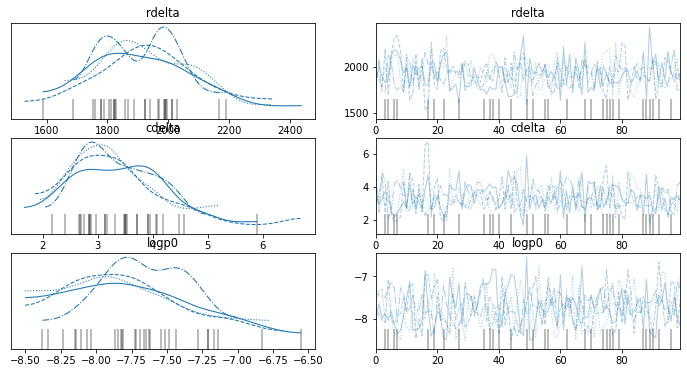

In [14]:
import arviz as az

az.plot_trace(tmhyd.trace, var_names=['rdelta', 'cdelta', 'logp0'])

Clearly the four individual chains return very similar results and the chains look well converged, even with just 100 steps and 100 tuning steps. We can also have a look at the posterior distributions for the parameters of interest

array([<AxesSubplot:title={'center':'rdelta'}>,
       <AxesSubplot:title={'center':'cdelta'}>], dtype=object)

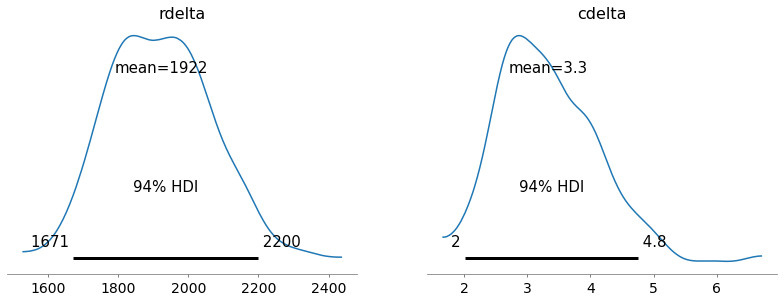

In [15]:
az.plot_posterior(tmhyd.trace, var_names=['rdelta', 'cdelta'])

To check the quality of the fit, _hydromass_ runs posterior predictive checks, i.e. it generates random datasets from the model including the expected statistical uncertainties. The generated values can then be compared to the data. The posterior predictive samples can be accessed through the _Mhyd.ppc_sb_ and _Mhyd.ppc_kt_ attributes of the Mhyd class. In the following example we compare the posterior predictive surface brightness distribution to the data to determine whether the model does an appropriate job at describing the data

/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<Axes:xlabel='Radius [arcmin]', ylabel='$S_{X}$ [cts/s/arcmin$^2$]'>

<Figure size 432x288 with 0 Axes>

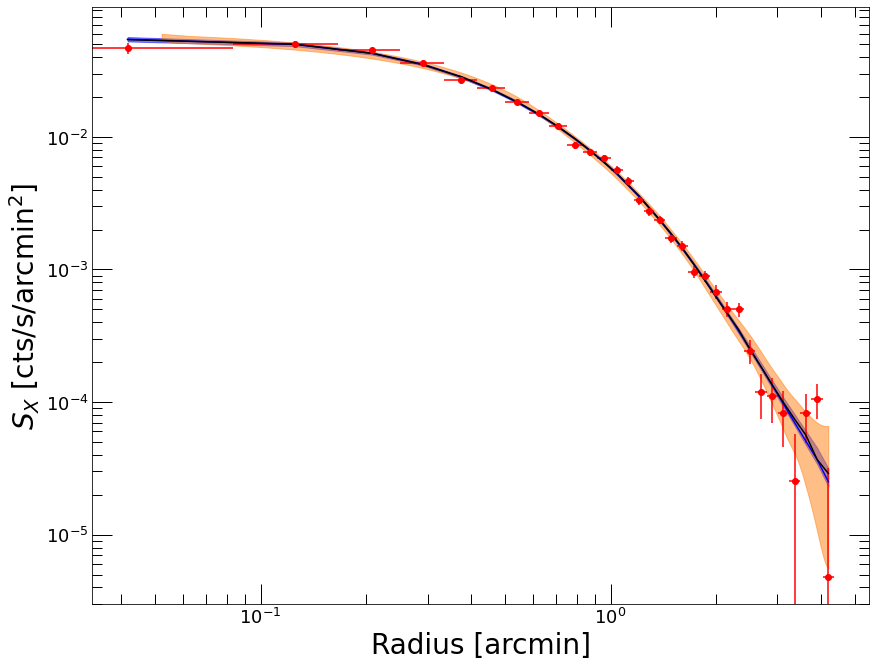

In [16]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$S_{X}$ [cts/s/arcmin$^2$]', fontsize=28)

plt.plot(p2.bins, tmhyd.sb, color='blue')
plt.fill_between(p2.bins, tmhyd.sb_lo, tmhyd.sb_hi, color='blue', alpha=0.5)
plt.errorbar(p2.bins, p2.profile, xerr=p2.ebins, yerr=p2.eprof, fmt='o', color='red')

plt.plot(p2.bins, np.median(tmhyd.ppc_sb['sb'], axis=0), color='black')

az.plot_hdi(
    p2.bins,
    tmhyd.ppc_sb['sb'],
    ax=ax,
    hdi_prob=.68,
)


Here the blue shaded area shows the best-fit model and its corresponding 1-sigma range, whereas the orange area represents the 68% confidence region of the generated posterior predictive samples. Clearly the model provides a very good representation of the data. 

We can now do the same thing with the temperature profile...

/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<Figure size 432x288 with 0 Axes>

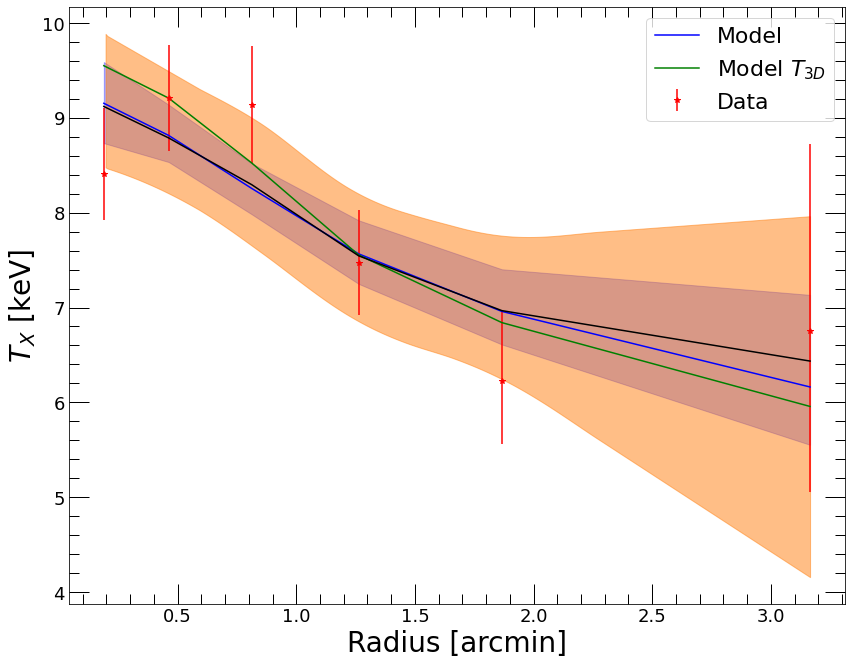

In [17]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$T_{X}$ [keV]', fontsize=28)
plt.errorbar(tmhyd.spec_data.rref_x_am,tmhyd.spec_data.temp_x,yerr=np.array([tmhyd.spec_data.templ,tmhyd.spec_data.temph]),fmt='*',color='red', label='Data')
plt.plot(tmhyd.spec_data.rref_x_am,tmhyd.ktmod,color='blue', label='Model')
plt.fill_between(tmhyd.spec_data.rref_x_am, tmhyd.ktmod_lo, tmhyd.ktmod_hi, color='blue', alpha=0.3)
plt.plot(tmhyd.spec_data.rref_x_am,tmhyd.kt3d,color='green', label='Model $T_{3D}$')

plt.plot(tmhyd.spec_data.rref_x_am, np.median(tmhyd.ppc_kt['kt'], axis=0), color='black')

az.plot_hdi(
    tmhyd.spec_data.rref_x_am,
    tmhyd.ppc_kt['kt'],
    ax=ax,
    hdi_prob=.68
)

plt.legend(fontsize=22)

Again the model seems to provide an accurate representation of the data, as all the data points are included within the orange range. Here we have plotted both the fitted projected spectroscopic-like temperatures in blue and the corresponding 3D temperatures in green.

Finally we can save the resulting samples to an output FITS file using the [hydromass.Mhyd.SaveModel](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.mhyd.Mhyd.SaveModel) method. The posterior parameter samples of the mass model and of the gas density model are saved and can be reloaded later on using the [hydromass.ReloadModel](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.save.ReloadModel) function.

In [18]:
tmhyd.SaveModel(model, outfile='mhyd/test_save.fits')

## Computing overdensity radii and masses ##

_hydromass_ allows the user to compute the radius within which the average density is equal to any user-defined overdensity from the fitted mass model. Namely, for each parameter and a given overdensity $\Delta$ the code searches for the radius within which

$$ \frac{M(<R_{\Delta})}{4/3\pi R_{\Delta}^3} = \Delta \rho_c $$

with $\rho_c$ the critical density of the Universe at the redshift of the system. The [hydromass.calc_rdelta_mdelta](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.delta.calc_rdelta_mdelta) numerically computes the posterior distributions of $R_\Delta$ and $M_\Delta=M(<R_\Delta)$. In the following we showcase the use of this function for $\Delta=500$

<Figure size 432x288 with 0 Axes>

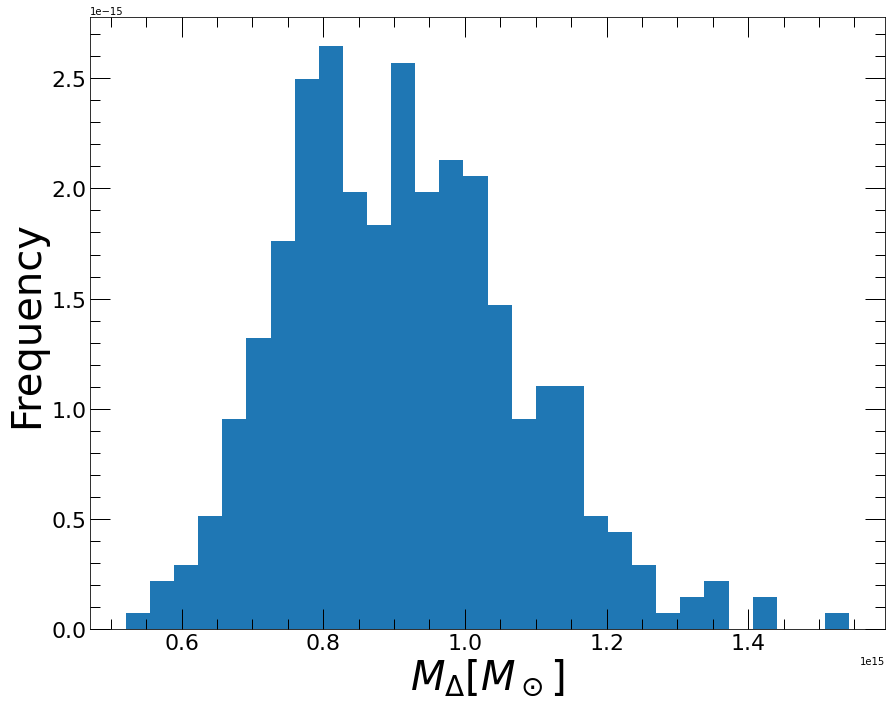

In [19]:
res_r500, fig = hydromass.calc_rdelta_mdelta(500, tmhyd, model, plot=True)

The output of the tool is a dictionary containing the median and 1-sigma error envelope of the overdensity radius, enclosed mass, gas mass, and gas fraction

In [20]:
res_r500

{'R_DELTA': 1230.408629178559,
 'R_DELTA_LO': 1156.5430426985383,
 'R_DELTA_HI': 1308.0279155045164,
 'M_DELTA': 903872856660106.2,
 'M_DELTA_LO': 750666028598378.2,
 'M_DELTA_HI': 1085951628867329.2,
 'MGAS_DELTA': 124496720553909.38,
 'MGAS_DELTA_LO': 118390032322143.97,
 'MGAS_DELTA_HI': 130725227913995.89,
 'FGAS_DELTA': 0.13835313016116085,
 'FGAS_DELTA_LO': 0.12078576719766834,
 'FGAS_DELTA_HI': 0.15815976138210708}

The [hydromass.write_all_mdelta](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.delta.write_all_mdelta) tool can be used to extract a diagnostic file including the best-fit overdensity radii and enclosed masses for $\Delta$=2500, 1000, 500, and 200. By default the results will be stored into a file entitled _MODEL.jou_ under the output directory, with _MODEL_ the name of the chosen mass model (here NFW).

In [21]:
hydromass.write_all_mdelta(tmhyd, model, rmin=100., rmax=4000.)

## Output mass profiles ##

The handy function [hydromass.mass_from_samples](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.plots.mass_from_samples) allows the user to extract posterior mass profiles within any user-defined radial range. The tool also extracts the cumulative gas mass profile and the corresponding hot gas fraction as a function of radius. The output profiles can be easily plotted from the data and saved into output files.

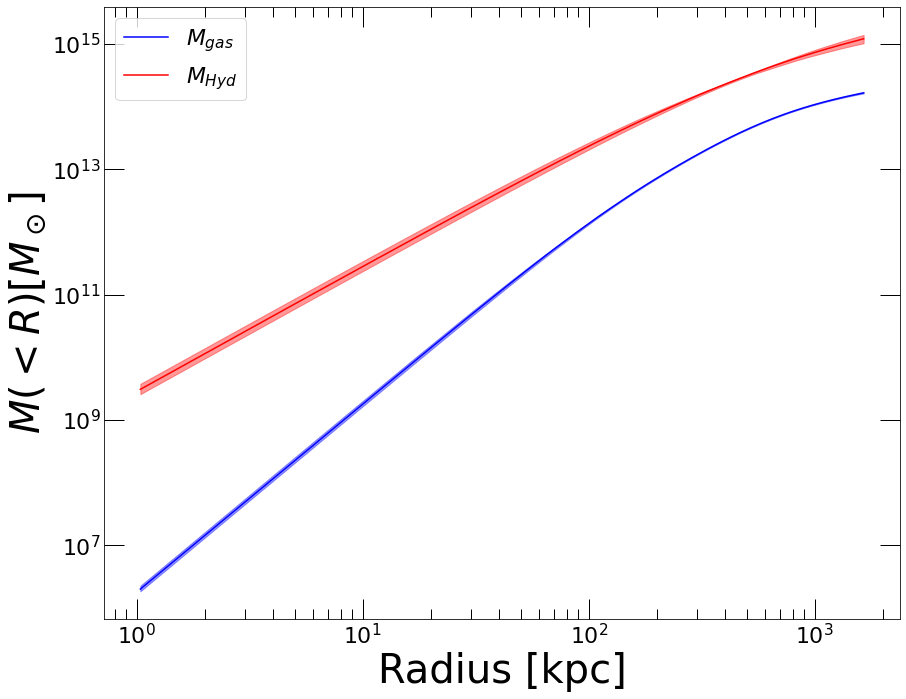

In [22]:
res_mass, fig = hydromass.mass_from_samples(Mhyd=tmhyd, 
                                       model=model,
                                       plot=True)


The output is a dictionary including the resulting mass profiles

In [23]:
res_mass.keys()

dict_keys(['R_IN', 'R_OUT', 'R_REF', 'MASS', 'MASS_LO', 'MASS_HI', 'M_DM', 'M_DM_LO', 'M_DM_HI', 'MGAS', 'MGAS_LO', 'MGAS_HI', 'FGAS', 'FGAS_LO', 'FGAS_HI', 'M_STAR'])

We can also have a look at the output gas fraction profile, defined as the ratio of cumulative gas mass to cumulative hydrostatic mass

$$ f_{gas}(r) = \frac{M_{gas}(<r)}{M_{Hyd}(<r)} $$

<Figure size 432x288 with 0 Axes>

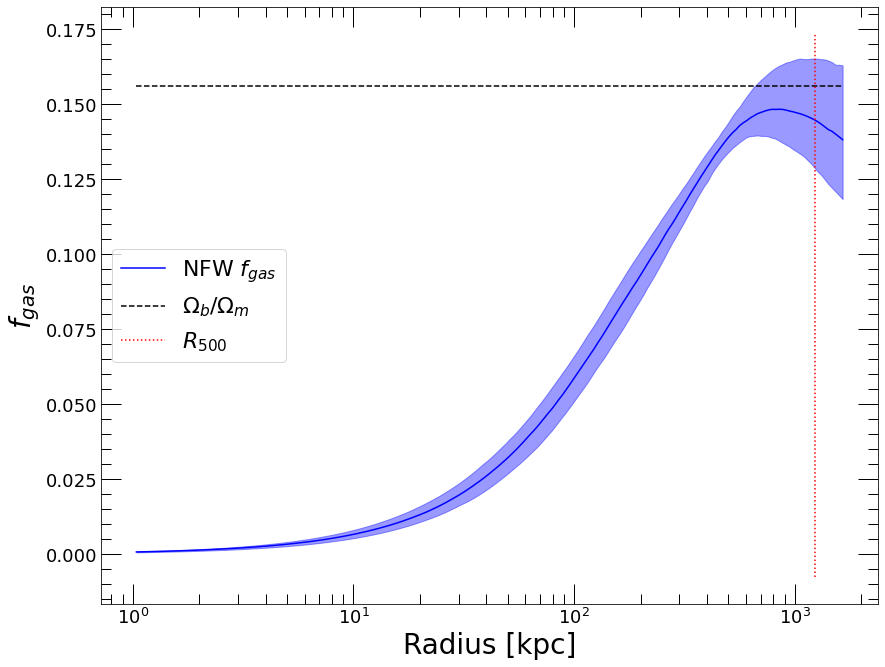

In [24]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xscale('log')
    
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$f_{gas}$', fontsize=28)

plt.plot(res_mass['R_OUT'], res_mass['FGAS'], color='blue', label='NFW $f_{gas}$')
plt.fill_between(res_mass['R_OUT'], res_mass['FGAS_LO'], res_mass['FGAS_HI'], color='blue', alpha=0.4)

ylim = ax.get_ylim()

plt.plot(res_mass['R_OUT'], 0.156*np.ones(len(res_mass['R_OUT'])), '--', color='black', label='$\Omega_b/\Omega_m$')

plt.plot([res_r500['R_DELTA'], res_r500['R_DELTA']], ylim, ':', color='red', label='$R_{500}$')

plt.legend(fontsize=22)

The hydrostatic gas fraction converges to a value that is very close to the cosmic baryon fraction at $R_{500}$. This is a good indication that the reconstruction is accurate.

We can now save the output profiles into an output FITS file through the [hydromass.SaveProfiles](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.save.SaveProfiles) tool,

In [25]:
hydromass.SaveProfiles(profiles=res_mass,
                      outfile='mhyd/NFW_mass_profile.fits',
                      extname='MASS PROFILE')